# Optimization Model Data Preparation

This notebook prepares and structures data for the charging network enhancement optimization model by:

1. Data Integration
   - Combining demographic insights
   - Merging EV ownership patterns
   - Integrating infrastructure assessments

2. Constraint Development
   - Grid capacity analysis
   - Budget constraint calculations
   - Coverage requirements definition

3. Parameter Calculation
   - Installation cost estimates
   - Operating cost projections
   - Coverage score calculations

4. Optimization Input Generation
   - Decision variable preparation
   - Constraint matrix creation
   - Objective function component calculation

This notebook serves as the bridge between our analysis and the optimization model, preparing all necessary inputs in the required format.

In [1]:
# Setup and imports
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime
import logging
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from tqdm import tqdm
from shapely.geometry import box, Point

# Local imports
from src.data.data_manager import DataManager
from src.data.constants import *
from src.data.utils import *
from src.visualization.map_viz import *

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize data manager
data_mgr = DataManager()

# Load processed data
print("\033[1m\033[94mLoading processed data...\033[0m")
population_data = load_latest_file(DATA_PATHS['population'], 'geojson')
charging_stations = load_latest_file(DATA_PATHS['charging_stations'], 'csv')
ev_data = load_latest_file(DATA_PATHS['ev_fsa_analyzed'], 'csv')
integrated_data = load_latest_file(DATA_PATHS['integrated_analyzed_data'], 'geojson')

print("\033[1m\033[92mData loaded successfully!\033[0m")

Loading processed data...
Data loaded successfully!


## 1. Station Analysis and Classification
First, let's analyze and classify all existing charging stations.

In [2]:
def analyze_stations():
    """
    Analyze and classify existing charging stations.
    Returns DataFrame with station classifications and metrics.
    """
    stations = charging_stations.copy()
    
    # Basic classification
    stations['is_l3'] = stations['charger_type'] == 'Level 3'
    stations['can_upgrade'] = (
        ~stations['is_l3'] & 
        (stations['num_chargers'] >= 2)  # Minimum size for upgrade
    )
    
    # Calculate distances between stations
    stations_gdf = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs="EPSG:4326"
    )
    
    # Calculate inter-station distances
    coords = stations[['longitude', 'latitude']].values
    distances = cdist(coords, coords)
    np.fill_diagonal(distances, np.inf)
    
    # Find nearest L3 charger for each station
    l3_mask = stations['is_l3'].values
    stations['nearest_l3_km'] = [
        min(distances[i][l3_mask]) if l3_mask.any() else np.inf
        for i in range(len(stations))
    ]
    
    return stations

# Analyze stations
station_analysis = analyze_stations()

print("\n📊 Station Analysis Summary:")
print("-" * 50)
print(f"Total Stations: {len(station_analysis)}")
print(f"Level 3 Chargers: {station_analysis['is_l3'].sum()}")
print(f"Upgrade Candidates: {station_analysis['can_upgrade'].sum()}")


📊 Station Analysis Summary:
--------------------------------------------------
Total Stations: 183
Level 3 Chargers: 16
Upgrade Candidates: 142


## 2. Constraint Parameter Calculation
Calculate key parameters for optimization constraints.

In [3]:
def calculate_constraint_parameters():
    """
    Calculate parameters for optimization constraints.
    Returns dict of constraint parameters.
    """
    # Installation costs (example values)
    costs = {
        'l2_to_l3_upgrade': 50000,  # Cost to upgrade L2 to L3
        'new_l2': 15000,            # Cost for new L2 installation
        'new_l3': 70000,            # Cost for new L3 installation
        'additional_port': 5000     # Cost per additional charging port
    }
    
    # Coverage requirements
    coverage_reqs = {
        'min_l3_coverage': 0.80,    # Minimum population coverage by L3
        'max_l3_distance': 5.0,     # Maximum distance between L3 chargers (km)
        'min_ports_per_area': 2     # Minimum ports per service area
    }
    
    # Grid capacity constraints (example)
    grid_capacity = {
        'max_l3_per_area': 3,       # Maximum L3 chargers per area
        'max_power_per_site': 350   # Maximum kW per site
    }
    
    return {
        'costs': costs,
        'coverage': coverage_reqs,
        'grid': grid_capacity
    }

# Calculate constraints
constraints = calculate_constraint_parameters()

## 3. Coverage and Demand Calculation
Calculate coverage metrics and demand projections.

In [4]:
def calculate_coverage_metrics():
    """
    Calculate population coverage by charging station type.
    Returns dict of coverage metrics and station counts.
    """
    # Create spatial objects for analysis
    stations_gdf = gpd.GeoDataFrame(
        station_analysis,
        geometry=gpd.points_from_xy(
            station_analysis.longitude,
            station_analysis.latitude
        ),
        crs="EPSG:4326"
    )
    stations_utm = stations_gdf.to_crs("EPSG:32617")
    
    # Prepare population data
    valid_pop_data = population_data[
        population_data.geometry.notna() & 
        population_data.geometry.is_valid &
        population_data['population'].notna() &
        (population_data['population'] > 0) &
        (population_data['data_source'] == 'Region of Waterloo')
    ].to_crs("EPSG:32617")
    
    def calculate_coverage(stations, radius_km=2.0):
        """Calculate population coverage within radius."""
        if len(stations) == 0:
            return 0.0
        
        coverage = 0.0
        total_pop = valid_pop_data['population'].sum()
        
        # Calculate coverage using station buffers
        station_buffers = stations.geometry.buffer(radius_km * 1000)
        unified_buffer = station_buffers.unary_union
        
        for idx, row in valid_pop_data.iterrows():
            if unified_buffer.intersects(row.geometry):
                intersection = unified_buffer.intersection(row.geometry)
                proportion = intersection.area / row.geometry.area
                coverage += row['population'] * proportion
        
        return coverage / total_pop if total_pop > 0 else 0.0
    
    # Calculate coverage by station type
    l3_stations = stations_utm[stations_utm['is_l3']]
    l2_stations = stations_utm[~stations_utm['is_l3']]
    
    l3_coverage = calculate_coverage(l3_stations, radius_km=5.0)
    l2_coverage = calculate_coverage(l2_stations, radius_km=2.0)
    
    print("\n📊 Coverage Analysis:")
    print("-" * 50)
    print(f"Level 3 Coverage: {l3_coverage:.1%}")
    print(f"Level 2 Coverage: {l2_coverage:.1%}")
    
    return {
        'l3_coverage': l3_coverage,
        'l2_coverage': l2_coverage,
        'l3_stations': len(l3_stations),
        'l2_stations': len(l2_stations),
        'total_population': float(valid_pop_data['population'].sum())
    }

# Calculate coverage metrics
coverage_metrics = calculate_coverage_metrics()


📊 Coverage Analysis:
--------------------------------------------------
Level 3 Coverage: 69.7%
Level 2 Coverage: 70.1%


## 4. Grid Capacity and Infrastructure Analysis
Analyze electrical grid capacity and infrastructure for potential upgrades.

In [5]:
# Define station loads as a global constant
STATION_LOADS = {
    'Level 2': 19.2,  # kW per station
    'Level 3': 350,   # kW per station
    'Unknown': 19.2   # Assume Level 2 for unknown types (conservative)
}

def analyze_grid_capacity():
    """
    Analyze grid capacity constraints for charging station upgrades.
    Uses infrastructure data and existing station loads to estimate capacity.
    """
    # Create spatial grid for capacity analysis
    stations_gdf = gpd.GeoDataFrame(
        station_analysis,
        geometry=gpd.points_from_xy(
            station_analysis.longitude,
            station_analysis.latitude
        ),
        crs="EPSG:4326"
    ).to_crs("EPSG:32617")  # Convert to UTM for accurate distances
    
    # First, let's check the charger types
    print("\nCharger Type Distribution:")
    print(stations_gdf['charger_type'].value_counts())
    
    # Add power requirements with error handling
    def calculate_power(row):
        charger_type = row['charger_type']
        num_chargers = row['num_chargers']
        # Use get() with default value of 19.2 for unknown types
        power_per_charger = STATION_LOADS.get(charger_type, 19.2)
        return power_per_charger * num_chargers
    
    stations_gdf['power_req'] = stations_gdf.apply(calculate_power, axis=1)
    
    # Create grid cells for capacity analysis
    xmin, ymin, xmax, ymax = stations_gdf.total_bounds
    cell_size = 2000  # 2km grid cells
    
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            cell = box(x0, y0, x0 + cell_size, y0 + cell_size)
            grid_cells.append(cell)
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs="EPSG:32617")
    
    # Calculate load per grid cell
    grid['current_load'] = 0.0
    grid['station_count'] = 0
    grid['l3_count'] = 0
    grid['l2_count'] = 0
    grid['unknown_count'] = 0
    
    for idx, cell in grid.iterrows():
        stations_in_cell = stations_gdf[stations_gdf.intersects(cell.geometry)]
        grid.loc[idx, 'current_load'] = stations_in_cell['power_req'].sum()
        grid.loc[idx, 'station_count'] = len(stations_in_cell)
        grid.loc[idx, 'l3_count'] = len(stations_in_cell[stations_in_cell['charger_type'] == 'Level 3'])
        grid.loc[idx, 'l2_count'] = len(stations_in_cell[stations_in_cell['charger_type'] == 'Level 2'])
        grid.loc[idx, 'unknown_count'] = len(stations_in_cell[stations_in_cell['charger_type'] == 'Unknown'])
    
    # Estimate capacity limits
    grid['capacity_limit'] = 1000  # 1MW per cell (example value)
    grid['available_capacity'] = grid['capacity_limit'] - grid['current_load']
    
    # Add visualization
    print(f"\nGrid Analysis Summary:")
    print(f"Total Cells: {len(grid)}")
    print(f"Cells with Stations: {(grid['station_count'] > 0).sum()}")
    print(f"Maximum Load in any Cell: {grid['current_load'].max():.1f} kW")
    print(f"Average Load per Active Cell: {grid[grid['station_count'] > 0]['current_load'].mean():.1f} kW")
    
    return grid

# Calculate grid capacity
grid_capacity = analyze_grid_capacity()

print("\n⚡ Grid Capacity Analysis:")
print("-" * 50)
print(f"Total Grid Cells: {len(grid_capacity)}")
print(f"Cells with Stations: {(grid_capacity['station_count'] > 0).sum()}")
print(f"Average Load per Cell: {grid_capacity['current_load'].mean():.1f} kW")
print(f"Cells at >80% Capacity: {(grid_capacity['current_load'] > 0.8 * grid_capacity['capacity_limit']).sum()}")


Charger Type Distribution:
charger_type
Level 2    166
Level 3     16
Unknown      1
Name: count, dtype: int64

Grid Analysis Summary:
Total Cells: 361
Cells with Stations: 63
Maximum Load in any Cell: 5772.8 kW
Average Load per Active Cell: 495.9 kW

⚡ Grid Capacity Analysis:
--------------------------------------------------
Total Grid Cells: 361
Cells with Stations: 63
Average Load per Cell: 86.5 kW
Cells at >80% Capacity: 11


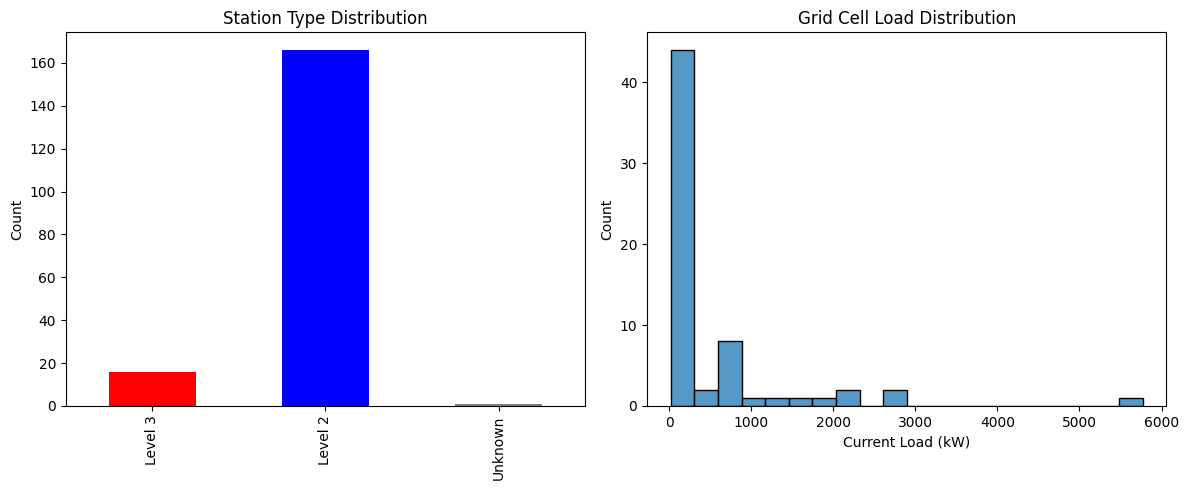

In [6]:
# Create summary visualization
plt.figure(figsize=(12, 5))

# Plot 1: Station Type Distribution
plt.subplot(1, 2, 1)
station_types = pd.Series({
    'Level 3': grid_capacity['l3_count'].sum(),
    'Level 2': grid_capacity['l2_count'].sum(),
    'Unknown': grid_capacity['unknown_count'].sum()
})
station_types.plot(kind='bar', color=['red', 'blue', 'gray'])
plt.title('Station Type Distribution')
plt.ylabel('Count')

# Plot 2: Grid Cell Load Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=grid_capacity[grid_capacity['current_load'] > 0], 
             x='current_load', bins=20)
plt.title('Grid Cell Load Distribution')
plt.xlabel('Current Load (kW)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [7]:
# Create visualization of grid capacity
m = create_kwc_map("Grid Capacity Analysis", kwc=True)

# Convert grid to WGS84
grid_wgs84 = grid_capacity.to_crs("EPSG:4326")

# Create color map
color_scale = LinearColormap(
    colors=['#ffffff', '#ffeda0', '#feb24c', '#f03b20'],
    vmin=0,
    vmax=max(100, grid_capacity['current_load'].max()),
    caption='Current Load (kW)'
)

# Add grid cells as a separate layer
grid_layer = folium.FeatureGroup(name='Grid Capacity')
for idx, row in grid_wgs84.iterrows():
    if row['current_load'] > 0:  # Only show cells with load
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, load=row['current_load']: {
                'fillColor': color_scale(load),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"Load: {row['current_load']:.1f} kW",
            popup=folium.Popup(
                f"""
                <div style="font-family: Arial;">
                    <b>Grid Cell {idx}</b><br>
                    Current Load: {row['current_load']:.1f} kW<br>
                    Available: {row['available_capacity']:.1f} kW<br>
                    Total Stations: {row['station_count']}<br>
                    - L3: {row['l3_count']}<br>
                    - L2: {row['l2_count']}<br>
                    - Unknown: {row['unknown_count']}
                </div>
                """
            )
        ).add_to(grid_layer)

grid_layer.add_to(m)

# Add stations as a separate layer
station_layer = folium.FeatureGroup(name='Charging Stations')
for idx, row in station_analysis.iterrows():
    color = 'red' if row['is_l3'] else 'blue'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        popup=f"""
        <div style="font-family: Arial; max-width: 200px;">
            <b>Station {idx}</b><br>
            Type: {row['charger_type']}<br>
            Ports: {row['num_chargers']}<br>
            Power: {STATION_LOADS.get(row['charger_type'], 19.2) * row['num_chargers']:.1f} kW
        </div>
        """
    ).add_to(station_layer)

station_layer.add_to(m)

# Add color scale and layer control
color_scale.add_to(m)
folium.LayerControl().add_to(m)

draw_map(m)

NameError: name 'LinearColormap' is not defined

In [ ]:
# Print statistics
print("\nGrid Load Statistics:")
print("-" * 50)
loaded_cells = grid_capacity[grid_capacity['current_load'] > 0]
print(f"Total Grid Cells: {len(grid_capacity)}")
print(f"Cells with Load: {len(loaded_cells)}")
print(f"Average Load in Active Cells: {loaded_cells['current_load'].mean():.1f} kW")
print(f"Maximum Load: {loaded_cells['current_load'].max():.1f} kW")
print(f"Cells at >80% Capacity: {(loaded_cells['current_load'] > 0.8 * loaded_cells['capacity_limit']).sum()}")


Grid Load Statistics:
--------------------------------------------------
Total Grid Cells: 361
Cells with Load: 63
Average Load in Active Cells: 495.9 kW
Maximum Load: 5772.8 kW
Cells at >80% Capacity: 11


## 5. Demand Pattern Analysis
Analyze temporal and spatial patterns of charging demand.

In [ ]:
def analyze_demand_patterns():
    """
    Analyze charging demand patterns using EV ownership and population data.
    """
    # Combine EV ownership with population data
    ev_gdf = gpd.GeoDataFrame(
        ev_data,
        geometry=gpd.points_from_xy(
            ev_data['longitude'] if 'longitude' in ev_data.columns else [-80.4925] * len(ev_data),
            ev_data['latitude'] if 'latitude' in ev_data.columns else [43.4516] * len(ev_data)
        ),
        crs="EPSG:4326"
    ).to_crs("EPSG:32617")
    
    # Calculate demand factors
    demand_analysis = {
        'current_demand': {
            'total_evs': ev_data['total_ev'].sum(),
            'bev_ratio': ev_data['bev'].sum() / ev_data['total_ev'].sum(),
            'avg_ev_density': ev_data['ev_density'].mean()
        },
        'growth_projections': {
            'annual_growth': 0.25,  # 25% annual growth
            'planning_horizon': 5,   # 5-year projection
            'l3_demand_increase': 0.15  # 15% increase in L3 charging demand
        },
        'temporal_patterns': {
            'peak_hours': ['08:00', '17:00'],
            'peak_usage_l2': 0.3,    # 30% utilization during peak
            'peak_usage_l3': 0.5     # 50% utilization during peak
        }
    }
    
    # Project future demand
    current_evs = demand_analysis['current_demand']['total_evs']
    growth_rate = demand_analysis['growth_projections']['annual_growth']
    horizon = demand_analysis['growth_projections']['planning_horizon']
    
    future_evs = current_evs * (1 + growth_rate) ** horizon
    
    demand_analysis['projections'] = {
        'current_evs': current_evs,
        'projected_evs': future_evs,
        'additional_evs': future_evs - current_evs
    }
    
    return demand_analysis

# Calculate demand patterns
demand_patterns = analyze_demand_patterns()

print("\n🚗 EV Demand Analysis:")
print("-" * 50)
print(f"Current EVs: {demand_patterns['current_demand']['total_evs']:,.0f}")
print(f"BEV Ratio: {demand_patterns['current_demand']['bev_ratio']:.1%}")
print(f"Projected EVs (5 year): {demand_patterns['projections']['projected_evs']:,.0f}")


🚗 EV Demand Analysis:
--------------------------------------------------
Current EVs: 9,881
BEV Ratio: 71.9%
Projected EVs (5 year): 30,154


## 6. Optimization Input Generation
Generate final matrices and parameters for the optimization model.

In [9]:
def generate_optimization_inputs():
    """
    Generate final input matrices and parameters for optimization model.
    """
    # Convert stations data to regular dictionary without geometry
    station_data = pd.DataFrame({
        'station_id': range(len(station_analysis)),
        'latitude': station_analysis['latitude'],
        'longitude': station_analysis['longitude'],
        'current_type': station_analysis['charger_type'],
        'current_ports': station_analysis['num_chargers'],
        'can_upgrade': station_analysis['can_upgrade'],
        'nearest_l3': station_analysis['nearest_l3_km']
    }).to_dict('records')
    
    # Coverage parameters (no geometry)
    coverage_params = {
        'current_l3': coverage_metrics['l3_coverage'],
        'current_l2': coverage_metrics['l2_coverage'],
        'target_l3': 0.90,  # Target 90% L3 coverage
        'max_distance': 5.0  # Maximum 5km between L3 chargers
    }
    
    # Grid capacity without geometry
    capacity_data = []
    for idx, row in grid_capacity.iterrows():
        if row['current_load'] > 0:
            capacity_data.append({
                'cell_id': idx,
                'current_load': float(row['current_load']),
                'available_capacity': float(row['available_capacity']),
                'station_count': int(row['station_count']),
                'l3_count': int(row['l3_count']),
                'l2_count': int(row['l2_count'])
            })
    
    # Demand weights
    demand_weights = {
        'current_ev_ratio': float(ev_data['bev_ratio'].mean()),
        'growth_factor': 0.25,  # 25% annual growth
        'l3_premium': 1.5  # Weight for L3 coverage vs L2
    }
    
    optimization_data = {
        'stations': station_data,
        'coverage': coverage_params,
        'capacity': capacity_data,
        'demand': demand_weights,
        'metadata': {
            'timestamp': datetime.now().isoformat(),
            'total_stations': len(station_analysis),
            'total_population': float(coverage_metrics['total_population'])
        }
    }
    
    return optimization_data

# Generate optimization inputs
opt_inputs = generate_optimization_inputs()

# Save using utility function
output_file, _ = save_data(
    data=opt_inputs,
    data_type='optimization_inputs',
    file_type='json'
)

print(f"\n💾 Optimization inputs saved!")
print(f"  📂 {output_file}")

# Print summary of saved data
print("\nOptimization Input Summary:")
print("-" * 50)
print(f"Stations: {len(opt_inputs['stations'])}")
print(f"Grid Cells with Load: {len(opt_inputs['capacity'])}")
print(f"Current L3 Coverage: {opt_inputs['coverage']['current_l3']:.1%}")
print(f"Target L3 Coverage: {opt_inputs['coverage']['target_l3']:.1%}")


💾 Optimization inputs saved!
  📂 /u1/a9dutta/co370/kw-ev-charging-optimization/data/processed/optimization_inputs/optimization_inputs_2024-11-24_10-30-15.json

Optimization Input Summary:
--------------------------------------------------
Stations: 183
Grid Cells with Load: 63
Current L3 Coverage: 69.7%
Target L3 Coverage: 90.0%
